# CNN

In [2]:
import torch
import torchmetrics
from ipykernel.kernelapp import kernel_flags
from notebook.app import launch_new_instance
from torch import nn, manual_seed, inference_mode

import torchvision
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchmetrics.functional import confusion_matrix
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from pytorch_workflow import MODEL_SAVE_PATH

print(f"torch: {torch.__version__} | torchvision: {torchvision.__version__}")

torch: 2.7.0+cpu | torchvision: 0.22.0+cpu


## getting a dataset

In [3]:
# setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
print(f"training examples: {len(train_data)} | test examples: {len(test_data)}")

training examples: 60000 | test examples: 10000


In [5]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
print(f"image shape: {image.shape} -> [color_channels, height, width]")
print(f"image label: {class_names[label]}")

image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
image label: Ankle boot


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

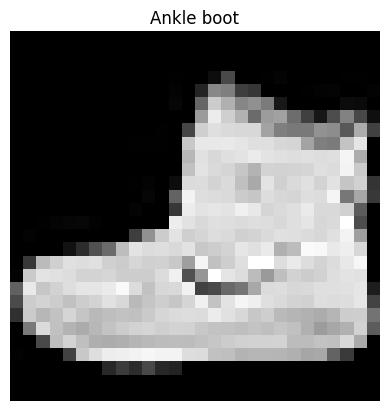

In [9]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

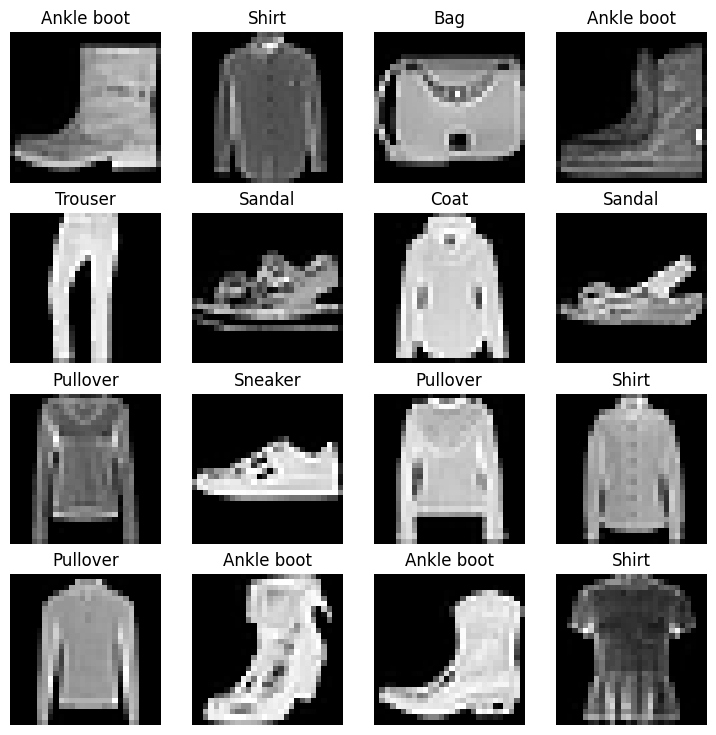

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## prepare dataloader

In [11]:
from torch.utils.data import DataLoader

# hyperparam
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x194477d37a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1944763dbb0>)

In [12]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)}, batches of: {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)}, batches of: {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000194477D37A0>, <torch.utils.data.dataloader.DataLoader object at 0x000001944763DBB0>)
Length of train_dataloader: 1875, batches of: 32
Length of test_dataloader: 313, batches of: 32


In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

img size: torch.Size([1, 28, 28])
label: 6, label size: torch.Size([])


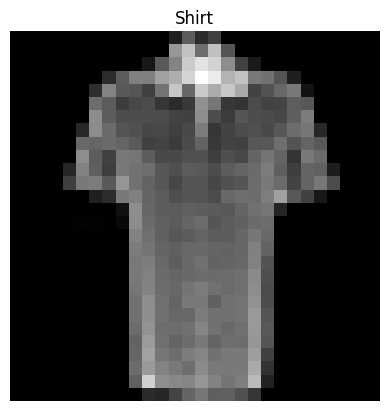

In [14]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"img size: {img.shape}")
print(f"label: {label}, label size: {label.shape}")

## building a baseline model

In [15]:
# create a flatten layer
flatten_model = nn.Flatten()

# get single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)  # perform forward pass

print(f"shape before: {x.shape}")
print(f"shape after: {output.shape}")
print(f"shape after squeezing: {output.squeeze().shape}")

shape before: torch.Size([1, 28, 28])
shape after: torch.Size([1, 784])
shape after squeezing: torch.Size([784])


In [16]:
from torch import nn


class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

# setup model w/ input params
model_0 = FashionMNISTModelV0(784, 10, len(class_names))  # 784 = output of flatten (28 * 28)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1, 1, 28, 28])
print(model_0(dummy_x))

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)


## downloading helper funcs

In [19]:
import requests
from pathlib import Path

# Download helper funcs
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("downloading helper_funcitons.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


## loss and optim and eval-metrics

In [20]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## creating a function to time our experiments

In [21]:
from timeit import default_timer as timer


def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """prints difference btw start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [22]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, device="cpu")

Train time on cpu: 0.000 seconds


2.9199989512562752e-05

## training loop on batches of data

In [23]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}\n-----")

    # TRAINING
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)

    # TESTING
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\ntrain loss: {train_loss:.4f} | test loss: {test_loss:.4f}, test acc: {test_acc:.4f}%")

train_time_end = timer()
total_train_time_model_0 = print_train_time(train_time_start, train_time_end,
                                            device=next(model_0.parameters()).device)

C:\Users\lhuen\PycharmProjects\MNIST-SiameseNetwork\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
-----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

train loss: 0.5904 | test loss: 0.5095, test acc: 82.0387%


 33%|███▎      | 1/3 [00:07<00:14,  7.04s/it]

epoch: 1
-----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

train loss: 0.4763 | test loss: 0.4799, test acc: 83.1969%


 67%|██████▋   | 2/3 [00:13<00:06,  6.99s/it]

epoch: 2
-----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

train loss: 0.4550 | test loss: 0.4766, test acc: 83.4265%


100%|██████████| 3/3 [00:20<00:00,  6.89s/it]


Train time on cpu: 20.669 seconds


## make preds and get model_0 results

In [26]:
torch.manual_seed(42)


def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """returns a dict containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # X, y = X.to(device), y.to(device)
            # make preds
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        # avg loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 342.45it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [27]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# model 1: building a better model with non linerarity

In [28]:
import torch
from torch import nn


class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [29]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [30]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

## functionizing training and testing loops

In [31]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"train loss: {train_loss:.5f}, train acc: {train_acc:.2f}%")

In [32]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    # TESTING
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"test loss: {test_loss:.5f}, test acc: {test_acc:.2f}%")

## train test loop

In [33]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}\n-------------------")
    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_step(model_1, train_dataloader, loss_fn, accuracy_fn)

train_time_end = timer()
total_train_time_model_1 = print_train_time(train_time_start, train_time_end,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
-------------------
train loss: 1.09199, train acc: 61.34%
test loss: 0.92727, test acc: 66.00%


 33%|███▎      | 1/3 [00:11<00:23, 11.85s/it]

epoch: 1
-------------------
train loss: 0.73779, train acc: 73.69%
test loss: 0.68793, test acc: 75.43%


 67%|██████▋   | 2/3 [00:23<00:11, 11.45s/it]

epoch: 2
-------------------
train loss: 0.66776, train acc: 76.08%
test loss: 0.64329, test acc: 76.87%


100%|██████████| 3/3 [00:33<00:00, 11.18s/it]


Train time on cpu: 33.535 seconds


In [34]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [35]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 374.40it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.68743497133255,
 'model_acc': 75.65894568690096}

# model 2: building a cnn

In [36]:
class FashionMNISTModelV2(nn.Module):
    """
    model architecture that replicates the TinyVGG
    model from cnn explainer website.
    """

    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [37]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [38]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [39]:
torch.manual_seed(42)
model_2_output = model_2(rand_image_tensor.unsqueeze(0))
print(model_2_output)
print(model_2_output.argmax(1))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)
tensor([2])


In [40]:
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"image batch shape: {images.shape}")
print(f"single image shape: {test_image.shape}")
print(f"test image: {test_image}")

image batch shape: torch.Size([32, 3, 64, 64])
single image shape: torch.Size([3, 64, 64])
test image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [41]:
torch.manual_seed(42)
# create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
conv_output = conv_layer(test_image)
conv_output, conv_output.shape

(tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
          [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
          [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
          ...,
          [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
          [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
          [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],
 
         [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
          [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
          [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
          ...,
          [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
          [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
          [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],
 
         [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
          [ 0.8117,  0.3191,

In [42]:
torch.manual_seed(42)
# create single maxpool2d layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)
maxpool_output = maxpool_layer(test_image)
maxpool_output, maxpool_output.shape

(tensor([[[ 1.9269,  2.2181,  0.6784,  ...,  0.7642,  1.8446,  1.3835],
          [ 1.9312,  0.9624,  1.6354,  ...,  0.8539,  1.0229,  0.7099],
          [ 0.5636,  1.0554,  0.4652,  ...,  0.4485,  0.8541,  1.2049],
          ...,
          [ 1.1233,  2.1158,  1.4051,  ...,  1.4307,  1.9144,  1.5664],
          [ 0.0515,  1.0802,  1.7977,  ...,  0.9106,  0.9991,  0.2425],
          [ 0.3076,  0.6421,  0.9172,  ...,  0.3761,  2.6678,  0.9416]],
 
         [[ 2.0818,  2.0741,  1.7054,  ...,  1.1078,  1.6612, -0.4319],
          [-0.1010,  0.8919,  0.5042,  ...,  0.5441,  1.2990,  1.8377],
          [ 0.6289,  1.0303,  0.1668,  ...,  1.2482,  2.4611,  1.8377],
          ...,
          [ 1.6984,  0.1371,  1.2942,  ...,  1.3265,  1.5168,  0.8127],
          [ 0.7342,  2.1091, -0.4260,  ...,  0.2568, -0.0400,  0.5846],
          [ 0.7205,  1.6574,  1.1300,  ...,  0.2673,  0.5409,  2.2465]],
 
         [[ 1.0261,  1.1465,  1.2445,  ...,  1.1764,  1.2134,  0.9354],
          [ 0.8466,  1.3186,

In [43]:
test_image.shape

torch.Size([3, 64, 64])

In [44]:
torch.manual_seed(42)
random_tensor = torch.randn(size=(1, 1, 4, 4))

maxpool_layer = nn.MaxPool2d(kernel_size=2)
maxpool_output = maxpool_layer(random_tensor)

random_tensor, maxpool_output

(tensor([[[[ 1.9269,  1.4873,  0.9007, -2.1055],
           [ 0.6784, -1.2345, -0.0431, -1.6047],
           [-0.7521,  1.6487, -0.3925, -1.4036],
           [-0.7279, -0.5594, -0.7688,  0.7624]]]]),
 tensor([[[[1.9269, 0.9007],
           [1.6487, 0.7624]]]]))

## setup loss and optim

In [45]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()
# train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    train_step(model=model_2, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer,
               accuracy_fn=accuracy_fn, device=device)
    test_step(model=model_2, data_loader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
end_time = timer()
total_train_time_model_2 = print_train_time(start_time, end_time, device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
train loss: 0.58819, train acc: 78.67%
test loss: 0.38070, test acc: 86.23%


 33%|███▎      | 1/3 [00:26<00:52, 26.34s/it]

epoch: 1
train loss: 0.36067, train acc: 86.93%
test loss: 0.35126, test acc: 87.72%


 67%|██████▋   | 2/3 [00:52<00:26, 26.14s/it]

epoch: 2
train loss: 0.32556, train acc: 88.24%
test loss: 0.31571, test acc: 88.51%


100%|██████████| 3/3 [01:20<00:00, 26.83s/it]


Train time on cpu: 80.505 seconds


In [47]:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)

100%|██████████| 313/313 [00:01<00:00, 183.15it/s]


In [48]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3381359279155731,
 'model_acc': 87.59984025559105}

In [49]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.687435,75.658946
2,FashionMNISTModelV2,0.338136,87.599840


In [50]:
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,20.669476
1,FashionMNISTModelV1,0.687435,75.658946,33.534933
2,FashionMNISTModelV2,0.338136,87.599840,80.504676


Text(0, 0.5, 'model')

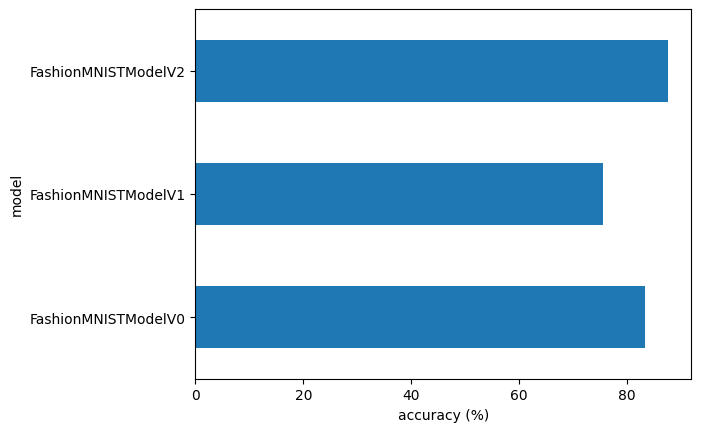

In [51]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## make and eval random preds

In [52]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

## visualize preds

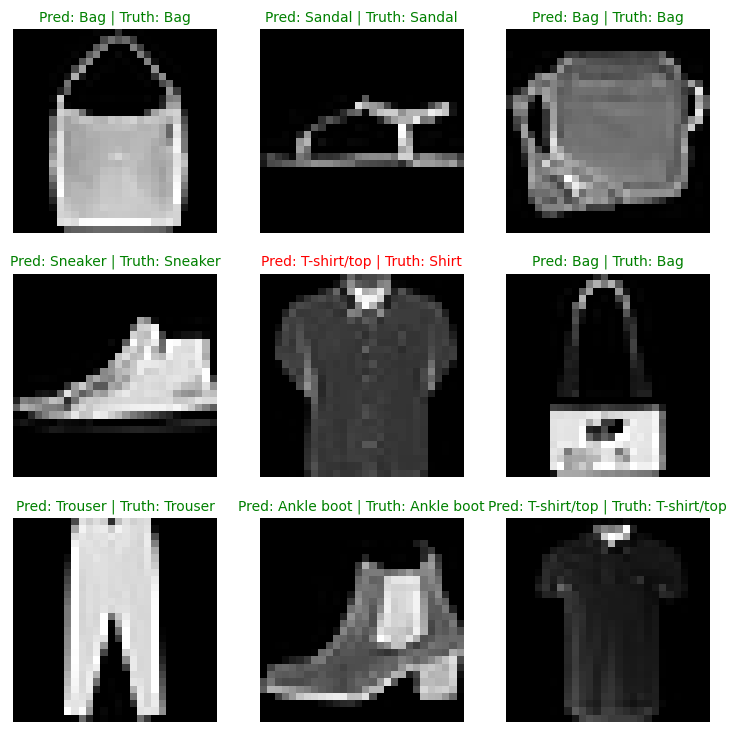

In [53]:
import random


def visualize_preds():
    # random.seed(42)
    test_samples = []
    test_labels = []
    for sample, label in random.sample(list(test_data), k=9):
        test_samples.append(sample)
        test_labels.append(label)

    pred_probs = make_predictions(model_2, test_samples)
    pred_classes = pred_probs.argmax(dim=1)

    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i + 1)

        plt.imshow(sample.squeeze(), cmap="gray")

        pred_label = class_names[pred_classes[i]]

        truth_label = class_names[test_labels[i]]

        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        # check for equality
        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")  # green if pred true
        else:
            plt.title(title_text, fontsize=10, c="r")  # red if pred false

        plt.axis(False)


visualize_preds()

## making a confusion matrix

In [54]:
import mlxtend

mlxtend.__version__

'0.23.4'

In [55]:
from tqdm.auto import tqdm

# make preds with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making preds..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
    print(y_preds)
    y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making preds...: 100%|██████████| 313/313 [00:01<00:00, 190.16it/s]


[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 3, 2, 4, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 6, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 4, 6, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 3, 7, 8, 7, 0, 2, 6, 4, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 3, 8]), tensor([6, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 8, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 2, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([7, 2, 3, 8, 0, 9, 4, 7, 8, 2, 6, 5, 4, 1, 2, 1, 3, 6, 9, 1, 0, 9, 3, 6,
        7, 9, 9, 4, 4, 7, 3, 2]), tensor([3, 2, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 3, 6, 7, 6, 7, 8, 9, 2, 9, 0, 5, 1, 4, 2, 5, 4, 9, 2, 2, 8, 6, 4,
        3, 4, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 6, 2, 3, 0, 8, 3, 7, 4,
       

tensor([9, 2, 1,  ..., 0, 1, 2])

In [56]:
try:
    import torchmetrics, mlxtend

    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend should be 0.19.0 or higher"
except:
    !pip install torchmetrics -U mlxtend
    import torchmetrics, mlxtend

    print("please install mlxtend lol")

mlxtend version: 0.23.4


In [57]:
import mlxtend

print(mlxtend.__version__)

0.23.4


In [58]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

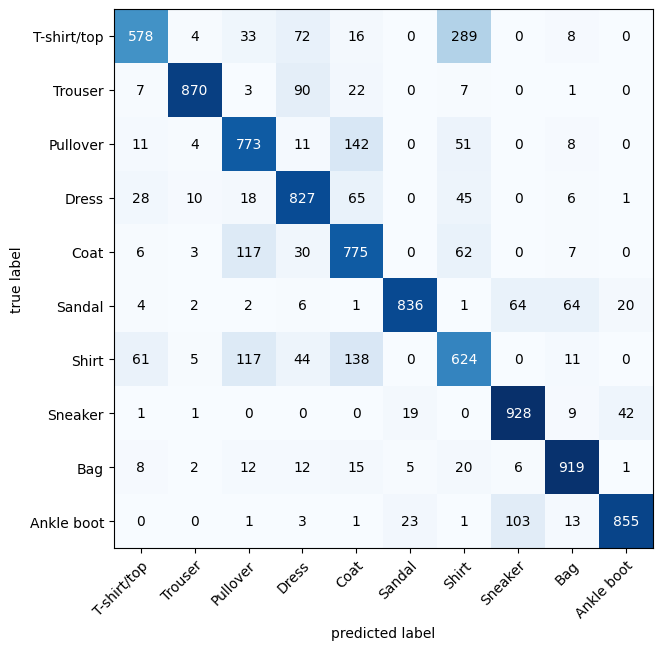

In [60]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## saving model

In [61]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to models\03_pytorch_computer_vision_model_2.pth


## loading model

In [62]:
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [63]:
torch.manual_seed(42)
loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
loaded_model_2_results

100%|██████████| 313/313 [00:01<00:00, 190.85it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3381359279155731,
 'model_acc': 87.59984025559105}

In [64]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)